In [5]:
import requests
import pandas as pd
import json
from dateutil import parser
import datetime as dt
import plotly.graph_objects as go

In [6]:
API_KEY = "747256ed65c7d1f36b050997ad0f2856-65843a1a530674432f7e7cc1374e0eb0"
ACCOUNT_ID = "101-004-29211030-001"
OANDA_URL = "https://api-fxpractice.oanda.com/v3/"

In [7]:
session = requests.Session()

In [8]:
session.headers.update({
    "Authorization" : f"Bearer {API_KEY}",
    "Content-Type" : "application/json"
})

In [9]:
params = dict(
    count = 10,
    granularity = "H1",
    price = "MBA"
)

In [10]:
url = f"{OANDA_URL}/accounts/{ACCOUNT_ID}/instruments"

In [11]:
response = session.get(url, params = None, data=None, headers=None)

In [12]:
response.status_code

200

In [13]:
data = response.json()

In [14]:
instruments_list = data["instruments"]

In [15]:
len(instruments_list)

123

In [16]:
instruments_list[0].keys()

dict_keys(['name', 'type', 'displayName', 'pipLocation', 'displayPrecision', 'tradeUnitsPrecision', 'minimumTradeSize', 'maximumTrailingStopDistance', 'minimumTrailingStopDistance', 'maximumPositionSize', 'maximumOrderUnits', 'marginRate', 'guaranteedStopLossOrderMode', 'tags', 'financing'])

In [17]:
key_1 = ['name', 'type', 'displayName', 'pipLocation', 'displayPrecision', 'tradeUnitsPrecision', 'marginRate']

In [18]:
instruments_dict = {}

for i in instruments_list:
    key = i["name"]
    instruments_dict[key] = {k : i[k] for k in key_1}

In [19]:
instruments_dict["USD_CAD"]

{'name': 'USD_CAD',
 'type': 'CURRENCY',
 'displayName': 'USD/CAD',
 'pipLocation': -4,
 'displayPrecision': 5,
 'tradeUnitsPrecision': 0,
 'marginRate': '0.03333333333333'}

In [20]:
with open("../data/instruments.json", "w") as f:
    f.write(json.dumps(instruments_dict, indent=2))

In [21]:
def fetch_candles(pair_name, count = 10, granularity="H1"):
    url = f"{OANDA_URL}/instruments/{pair_name}/candles"
    params = dict(
        count = count,
        granularity = granularity,
        price = "MBA"
    )
    response = session.get(url, params = params, data=None, headers=None)
    data = response.json()

    if response.status_code == 200:
        if 'candles' not in data:
            data = []
        else:
            data = data['candles']
    return response.status_code, data

def get_candles_df(data):
    if len(data) == 0:
        return pd.DataFrame()

    prices = ['mid', 'bid', 'ask']
    ohlc = ['o', 'h', 'l', 'c']
    final_data = []
    for candle in data:
        if candle['complete'] == False:
            continue
        new_dict = {}
        new_dict["time"] = parser.parse(candle["time"])
        new_dict["volume"] = candle["volume"]
        for p in prices:
                for o in ohlc:
                    new_dict[f"{p}_{o}"] = float(candle[p][o])
        final_data.append(new_dict)
    
    df = pd.DataFrame.from_dict(final_data)
    return df

def create_data_file(pair_name, count=10, granularity="H1"):
    code, data = fetch_candles(pair_name, count, granularity)
    if code != 200:
        print("Failed", pair_name, data)
        return
    if len(data) == 0:
        print("No candles", pair_name)
    candles_df = get_candles_df(data)
    candles_df.to_pickle(f"../data/{pair_name}_{granularity}.pkl")
    print(f"{pair_name} {granularity} {candles_df.shape[0]} candles, {candles_df.time.min()} {candles_df.time.max()}")
    

In [22]:
code, data = fetch_candles("EUR_USD", count = 10, granularity="H4")
condles_df = get_candles_df(data)

In [47]:
dt_plot=create_data_file('EUR_USD', count=4100, granularity="H4")

EUR_USD H4 4099 candles, 2021-10-27 17:00:00+00:00 2024-06-13 17:00:00+00:00


In [24]:
our_curr = ['EUR', 'USD', 'GBP', 'JPY', 'CHF', 'NZD', 'CAD', 'AUD']

In [25]:
for p1 in our_curr:
    for p2 in our_curr:
        pr = f"{p1}_{p2}"
        if pr in instruments_dict:
            for g in ["H1", "H4"]:
                create_data_file(pr, count=4001, granularity=g)

EUR_USD H1 4000 candles, 2023-10-23 05:00:00+00:00 2024-06-13 22:00:00+00:00
EUR_USD H4 4000 candles, 2021-11-19 06:00:00+00:00 2024-06-13 17:00:00+00:00
EUR_GBP H1 4000 candles, 2023-10-23 05:00:00+00:00 2024-06-13 22:00:00+00:00
EUR_GBP H4 4000 candles, 2021-11-19 06:00:00+00:00 2024-06-13 17:00:00+00:00
EUR_JPY H1 4000 candles, 2023-10-23 05:00:00+00:00 2024-06-13 22:00:00+00:00
EUR_JPY H4 4000 candles, 2021-11-18 22:00:00+00:00 2024-06-13 17:00:00+00:00
EUR_CHF H1 4000 candles, 2023-10-23 05:00:00+00:00 2024-06-13 22:00:00+00:00
EUR_CHF H4 4000 candles, 2021-11-19 06:00:00+00:00 2024-06-13 17:00:00+00:00
EUR_NZD H1 4000 candles, 2023-10-23 07:00:00+00:00 2024-06-13 22:00:00+00:00
EUR_NZD H4 4000 candles, 2021-11-19 14:00:00+00:00 2024-06-13 17:00:00+00:00
EUR_CAD H1 4000 candles, 2023-10-23 05:00:00+00:00 2024-06-13 22:00:00+00:00
EUR_CAD H4 4000 candles, 2021-11-19 06:00:00+00:00 2024-06-13 17:00:00+00:00
EUR_AUD H1 4000 candles, 2023-10-23 05:00:00+00:00 2024-06-13 22:00:00+00:00

In [56]:
pair = 'EUR_USD'
granularity='H4'
df=pd.read_pickle(f"../data/{pair}_{granularity}.pkl")

In [69]:
df['sTime'] = [dt.datetime.strftime(x, "s%t-%m-%d %H:%M") for x in df.time]

In [71]:

dt_plot = df.iloc[:100]

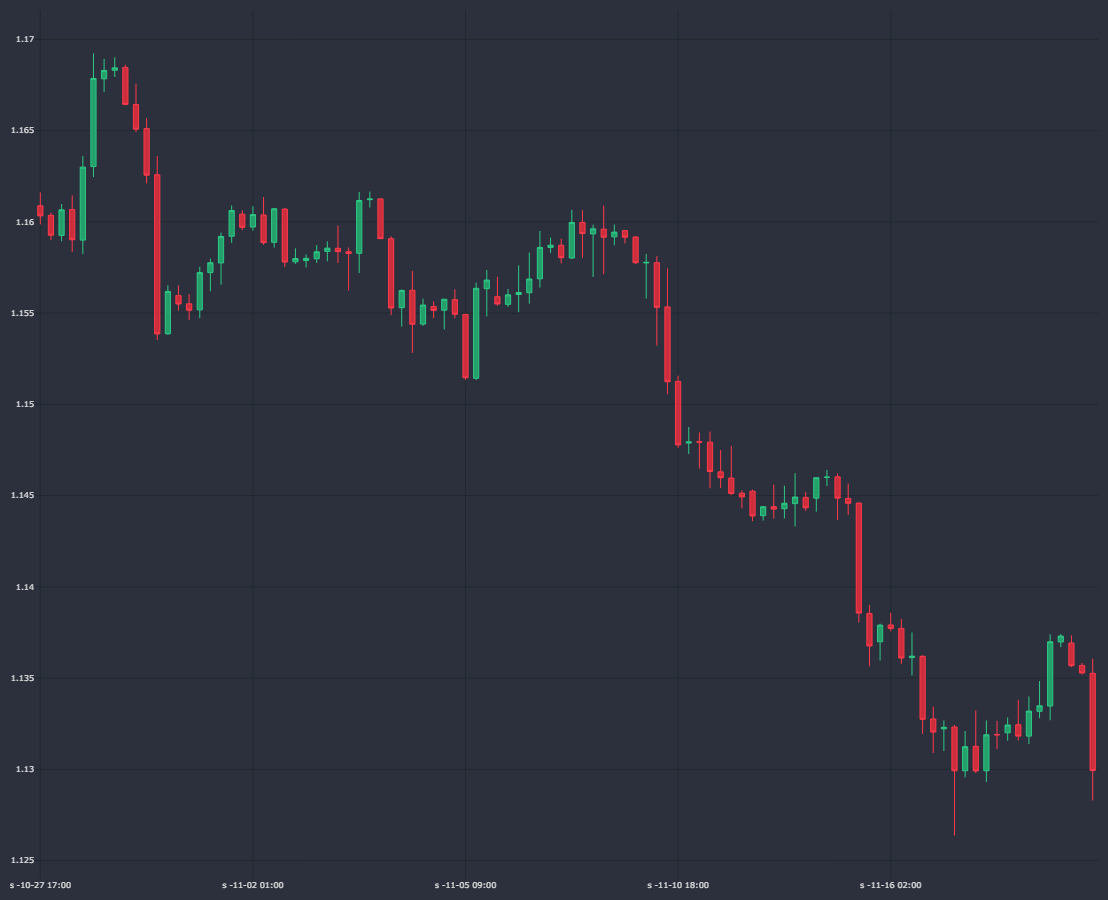

In [72]:

fig = go.Figure()
fig.add_trace(go.Candlestick(
    x=dt_plot.sTime,
    open=dt_plot.mid_o,
    high=dt_plot.mid_h,
    low=dt_plot.mid_l,
    close=dt_plot.mid_c,
    line=dict(width=1),
    opacity=1,
    increasing_fillcolor='#24A06B',
    decreasing_fillcolor='#CC2E3C',
    increasing_line_color='#2EC886',
    decreasing_line_color='#FF3A4C',
    )
        )

fig.update_yaxes(
    gridcolor= "#1f292f"
)

fig.update_xaxes(
    gridcolor= "#1f292f",
    rangeslider=dict(visible=False),
    nticks=5
)

fig.update_layout(
    width=1100,
    height=900,
    margin=dict(l=10,r=10,b=10,t=10),
    paper_bgcolor= "#2c303c",
    plot_bgcolor= "#2c303c",
    font=dict(size=8,color='#e1e1e1')
)